# Earthquakes in Mexico

Data from:  

 - [Servicio Sismológico Nacional](http://www2.ssn.unam.mx:8080/catalogo/)
 - Shapefile Mexico: Capa descargada de http://tapiquen-sig.jimdo.com. Carlos Efraín Porto Tapiquén. Orogénesis Soluciones Geográficas. Porlamar, Venezuela, 2015.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import pandas as pd
import re
import csv
import datetime as dt

In [41]:
def read_csv(file):
    """
    Custom read because the SSNMX's csv file sucks!
    """
    date = re.compile(r"^\d{4}-\d{2}-\d{2}")
    read_data = []
    with open(file) as readable:
        reader = csv.reader(readable)
        for data in reader:
            if date.match(data[0]):
                
                date_time_obj = dt.datetime.strptime(data[7] + " " + data[8], '%Y-%m-%d %H:%M:%S')
                read_data.append([
                    float(data[2]),
                    float(data[3]),
                    float(data[4]),
                    float(data[5]),
                    date_time_obj
                ])               
    return pd.DataFrame(read_data, columns=["Magnitud","Latitud","Longitud","Profundidad","Time UTC"])
        
earthquakes = read_csv("SSNMX_catalogo_20180101_20181231.csv")
earthquakes.head()

,Magnitud,Latitud,Longitud,Profundidad,Time UTC
0,3.6,16.2055,-95.2493,10.0,2018-01-01 06:03:58
1,3.9,14.8662,-94.2382,15.7,2018-01-01 06:06:20
2,3.5,15.6873,-94.8843,16.3,2018-01-01 06:26:53
3,3.1,16.0598,-97.5302,36.5,2018-01-01 06:35:53
4,3.7,18.1777,-98.8718,16.1,2018-01-01 06:50:14


In [42]:
map_df = gpd.read_file("Mexico_Estados/Mexico_Estados.shp")
map_df.head()

,CODIGO,ESTADO,geometry
0,MX02,Baja California,"MULTIPOLYGON (((-113.13972 29.01778, -113.2405..."
1,MX03,Baja California Sur,"MULTIPOLYGON (((-111.20612 25.80278, -111.2302..."
2,MX18,Nayarit,"MULTIPOLYGON (((-106.62108 21.56531, -106.6475..."
3,MX14,Jalisco,"POLYGON ((-101.52490 21.85664, -101.58830 21.7..."
4,MX01,Aguascalientes,"POLYGON ((-101.84620 22.01176, -101.96530 21.8..."


In [43]:
def parse_dublin_core(dublin_core):
    """
    Parses `DublinCore` bounding box specifications to return 
    the westlimit, southlimit, eastlimit and northlimit in that order
    """
    return [float(part.split("=")[1][:-1]) for part in dublin_core.split(";")]

def average(data):
    averages = np.zeros(len(data)-1)
    for i in range(len(data)-1):
        averages[i] = (data[i] + data[i+1]) / 2
    return averages


In [44]:
w, s, e, n = parse_dublin_core("westlimit=-105.68; southlimit=13.79; eastlimit=-92.04; northlimit=20.14")
coordinates_range = [[w, e], [s, n]]
values, xedges, yedges = np.histogram2d(earthquakes["Longitud"].values, 
                                        earthquakes["Latitud"].values,
                                        range=coordinates_range,
                                        bins=[600, 100])

xcenters = average(xedges)
ycenters = average(yedges)
xv, yv = np.meshgrid(xcenters, ycenters, sparse=False, indexing='ij')

In [88]:
end = earthquakes["Time UTC"].max().tz_localize(tz = 'UTC').tz_convert(tz = 'America/Mexico_City').to_pydatetime()
start = earthquakes["Time UTC"].min().tz_localize(tz = 'UTC').tz_convert(tz = 'America/Mexico_City').to_pydatetime()
title = f"Frequency of earthquakes in Mexico ({start:%Y/%m/%d} - {end:%Y/%m/%d})"
print(title)

Frequency of earthquakes in Mexico (2018/01/01 - 2018/12/31)


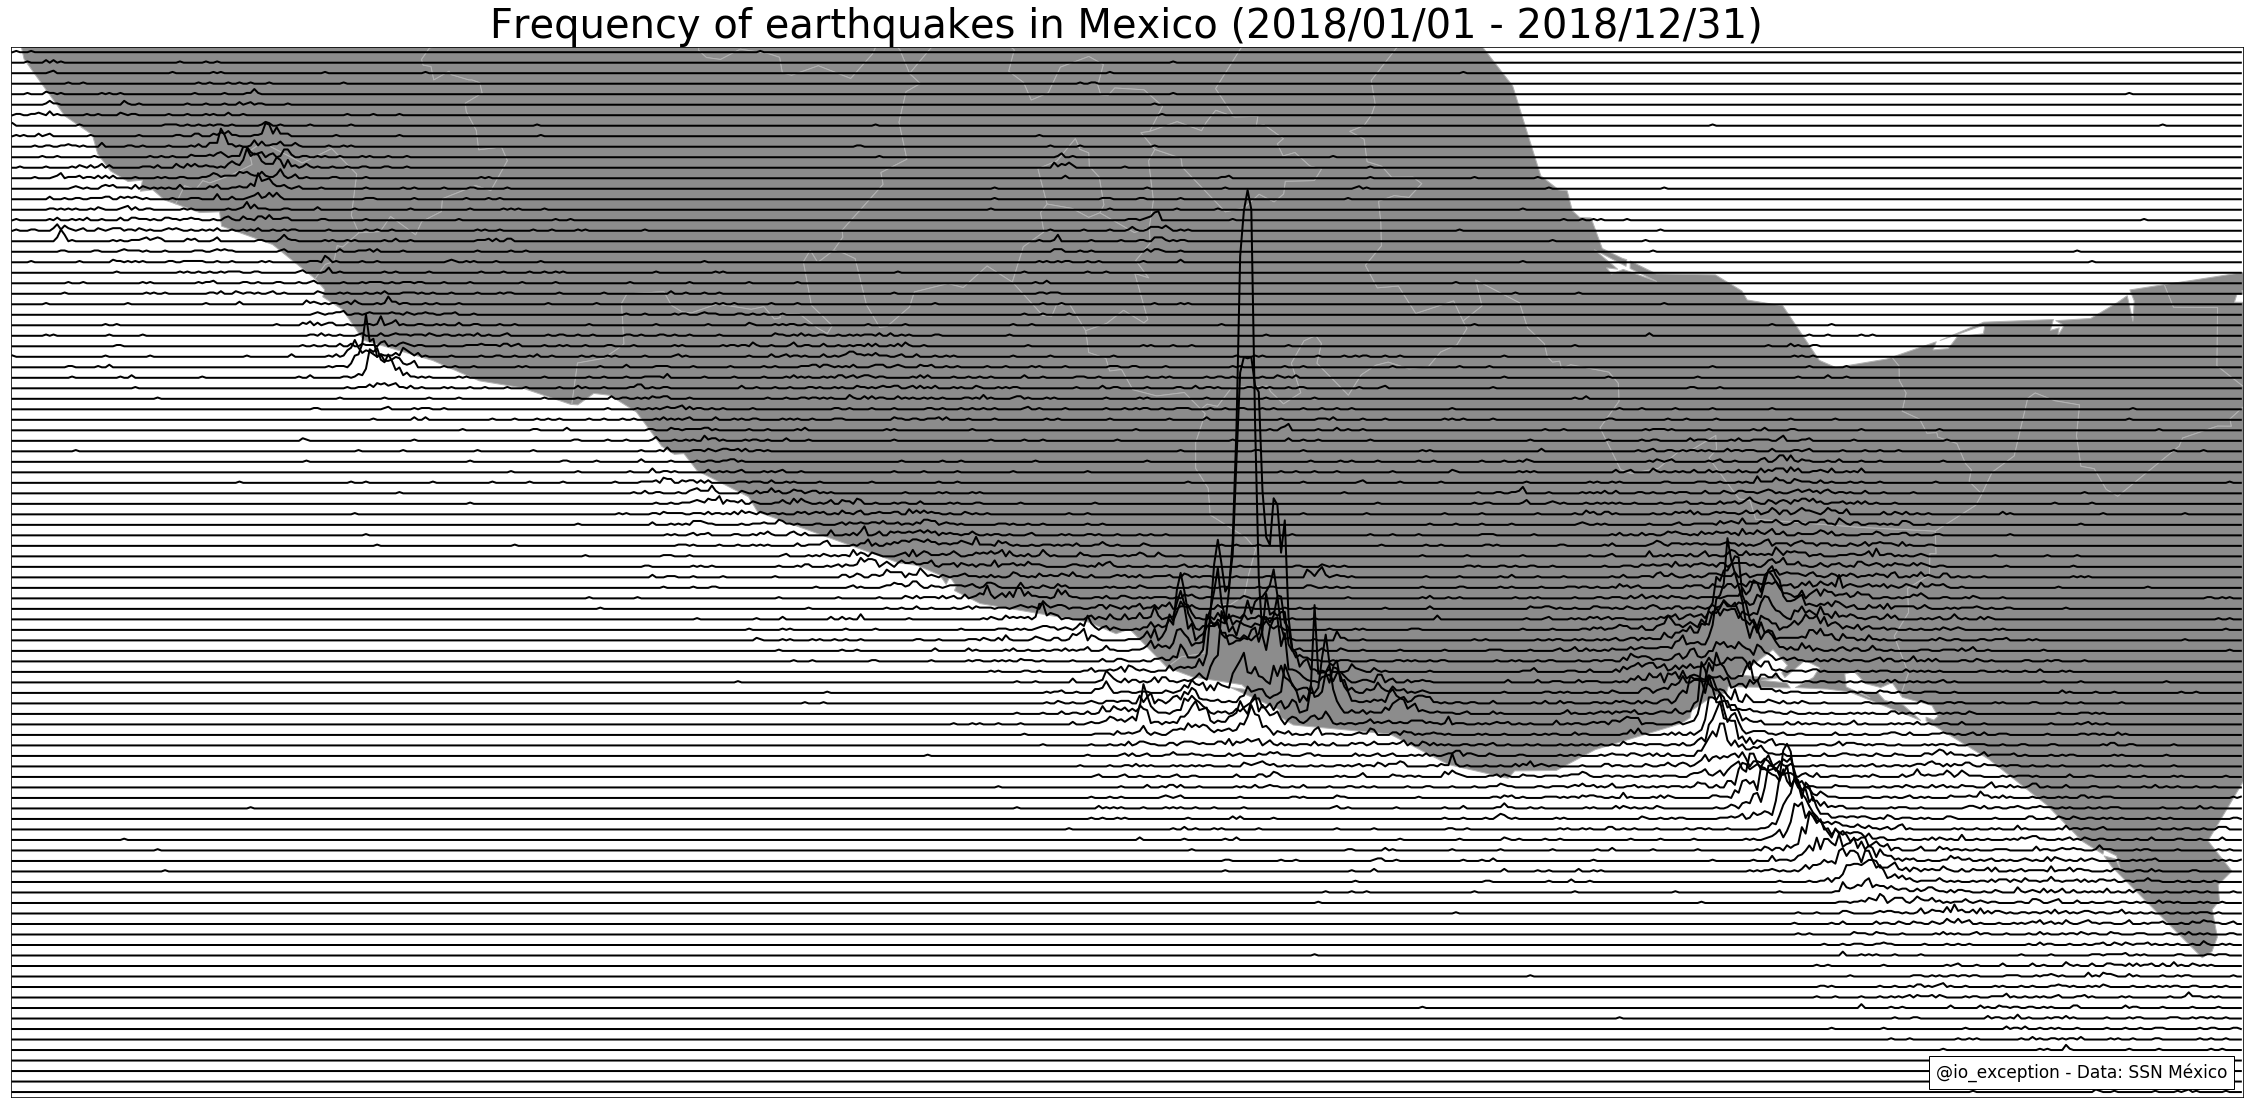

In [97]:
from mpl_toolkits.axisartist.axis_artist import AxisArtist

scaled_values = (values / values.max())*3
plt.figure(figsize=(40,20))
ax = plt.gca()
map_df.plot(color='#8C8C8C', edgecolor='#B3B3B3',ax=ax)
for i in range(len(ycenters)):
    plt.plot(xv[:,i], scaled_values[:,i] + ycenters[i], c="black", linewidth=2)
ax.set_xlim(coordinates_range[0])
ax.set_ylim(coordinates_range[1])
ax.set_xticks([], [])
ax.set_yticks([], [])
plt.title(title, size=40)
text = AnchoredText("@io_exception - Data: SSN México", loc=4,
                    prop={'size': 17}, frameon=True)
ax.add_artist(text)
plt.savefig("earthquakes.png")